## Projeto de Redes Sociais

In [84]:
import freeman as fm
import seaborn as sns
import statsmodels.api as sm
import networkx as nx
import pylab
from collections import defaultdict



In [85]:
g = fm.load('data/lol_teams.gml')

In [86]:
g.set_all_nodes(size=15, labpos='hover')

# Deixar as arestas semi-transparentes para
# a visualização ficar um pouco mais leve.
# g.set_all_edges(color=(0, 0, 0, 0.25))

# Usar um algoritmo especial para posicionar
# os nós de acordo com grupos.
g.move('kamada_kawai')

g.draw()

In [90]:
teams_bet = nx.betweenness_centrality(g)
teams_bet = [bet for bet in teams_bet.values()]

teams_perf = []
for n in g.nodes:
    teams_perf.append(g.nodes[n]['perf'])

<ipython-input-88-49f3a02a2ee2>:6: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



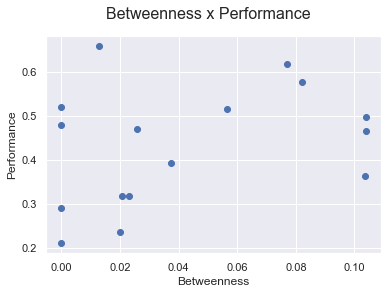

In [88]:
ax = pylab.subplot(111)
ax.scatter(teams_bet, teams_perf)
pylab.xlabel('Betweenness')
pylab.ylabel('Performance')
pylab.suptitle('Betweenness x Performance', fontsize=16)
ax.figure.show()

In [89]:
model = sm.OLS(teams_perf, teams_bet)
result = model.fit()
result.summary()

C:\Users\lchen\anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=16



<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.588
Model:                            OLS   Adj. R-squared (uncentered):              0.561
Method:                 Least Squares   F-statistic:                              21.44
Date:                Thu, 12 Nov 2020   Prob (F-statistic):                    0.000327
Time:                        23:07:13   Log-Likelihood:                         -2.8921
No. Observations:                  16   AIC:                                      7.784
Df Residuals:                      15   BIC:                                      8.557
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             6.0968      1.317      4.630      0.000       3.290       8.903
==============================================================================
Omnibus:                        0.111   Durbin-Watson:                   0.927
Prob(Omnibus):                  0.946   Jarque-Bera (JB):                0.172
Skew:                          -0.146   Prob(JB):                        0.918
Kurtosis:                       2.584   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""